# Gaussian process regression



### Table of contents

1. [**Data**](#data)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)

This notebook contains code demonstrating how to do regression.
- Linear regression
- Fitting a spike train with a renewal process GP
- Computing the renewal process likelihood landscape
- Performing GPLVM on a biological data for dimensionality reduction

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")

In [4]:
import neuroppl as nppl
import neuroppl.utils as utils

dev = utils.pytorch.get_device() # PyTorch device, gpu 0 by default if available

PyTorch version: 1.7.1+cu101
Using device: cuda:0


### SVGP
We use sparse kernel methods to fit kernel regression and get uncertainty estimates.

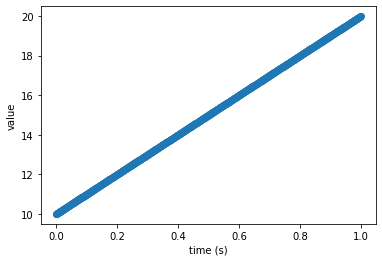

In [10]:
tbin = 1. # rate = output ratio
steps = 1000
max_time = tbin*steps*0.001
y_dims = 1
in_dims = 1

rate = np.empty((y_dims, steps))
rate[0] = 0.01*np.arange(steps) + 10.
y = rate + 2.*np.random.randn(y_dims, steps)

cov = np.arange(steps)*tbin*0.001 # time points to evaluate

plt.scatter(cov, rate[0])
plt.xlabel('time (s)')
plt.ylabel('value')
plt.show()

In [20]:
v = 1.*torch.ones(y_dims)

#('linear', 'euclid', np.empty((1, y_dim)))]
                  #('polynomial', 'euclid', np.zeros(y_dim), 2)]
                  #('RBF', 'euclid', np.ones((1, y_dim)))]
                  #('Matern32', 'euclid', np.ones((1, y_dim)))]
                  #('RQ', 'euclid', np.ones((1, y_dim)), np.ones(y_dim))]
    


constraints = []
krn_1 = nppl.kernels.kernel.Constant(variance=v, tensor_type=torch.float)
krn_2 = nppl.kernels.kernel.Linear(
    input_dims=in_dims, 
    track_dims=[0], tensor_type=torch.float
)

kernel = nppl.kernels.kernel.Product(krn_1, krn_2)

num_induc = 8
Xu = torch.tensor(
    [np.linspace(0, max_time, num_induc)]
).T[None, ...].repeat(y_dims, 1, 1)
inducing_points = nppl.kernels.kernel.inducing_points(y_dims, Xu, constraints)



input_data = [torch.from_numpy(cov)]

In [21]:
# mapping
in_dims = Xu.shape[-1]

gpr = nppl.mappings.GP.SVGP(
    in_dims, y_dims, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(y_dims), learn_mean=True
)

In [22]:
### inputs and likelihood ###
input_group = nppl.inference.input_group()
input_group.set_XZ(input_data, steps, batch_info=500)


likelihood = nppl.likelihoods.Gaussian(y_dims, 'exp', log_var=torch.zeros(y_dims))
likelihood.set_Y(torch.from_numpy(y), batch_info=500) 


glm = nppl.inference.VI_optimized(input_group, gpr, likelihood)
glm.to(dev)

VI_optimized(
  (input_group): input_group()
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): Linear()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Gaussian()
)

In [23]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 5*1e-3}

glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0
losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, ll_mode='MC')

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

ValueError: Loss diverged

In [ ]:
def posterior_rate(mapping, likelihood, covariates, MC, F_dims, trials=1, percentiles=[0.05, .5, 0.95]):
    """
    Sample F from diagonalized variational posterior.
    
    :returns: F of shape (MCxtrials, outdims, time)
    """
    cov = mapping.to_XZ(covariates, trials)
    with torch.no_grad():
        if mapping.MC_only:
            F = mapping.sample_F(cov)[:, F_dims, :] # TODO: cov_samples vs ll_samples?
            samples = likelihood.f(F.view(-1, trials, *samples.shape[1:]))
        else:
            F_mu, F_var = mapping.compute_F(cov)
            samples = likelihood.sample_rate(
                F_mu[:, F_dims, :], F_var[:, F_dims, :], trials, MC)
    
    return utils.signal.percentiles_from_samples(samples, percentiles)

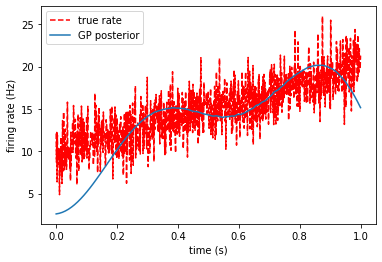

In [26]:
# compare to true rate
steps= 100
show_neurons = [0]
covariates = [np.linspace(0.0, max_time, steps)]

mean = rate_model.eval_rate(covariates, show_neurons, True)
for k, neuron in enumerate(show_neurons):
    
    fig, ax = plt.subplots()
    
    ax.plot(np.linspace(0, max_time, rate.shape[1]), rate[neuron], 'r--', label='true rate')
    line, = ax.plot(covariates[0], mean[k], label='model fit')
    #ax.fill_between(
    #    covariates[0], lower[k],
    #    upper[k], color=line.get_color(), alpha=0.5
    #)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
plt.show()

### Spectral mixture kernel

In [ ]:
class Lengthscale(Kernel):
    """ """

    def __init__(
        self,
        input_dims,
        lengthscale,
        w,
        omega,
        Q,
        track_dims=None,
        topology="euclid",
        f="exp",
        tensor_type=torch.float,
    ):
        super().__init__(input_dims, topology, lengthscale, track_dims, f, tensor_type)



class SpectralMixture(Lengthscale):
    r"""
    Implementation of Radial Basis Function kernel:

        :math:`k(x,z) = \exp\left(-0.5 \times \frac{|x-z|^2}{l^2}\right).`

    .. note:: This kernel also has name `Squared Exponential` in literature.
    """

    def __init__(
        self,
        input_dims,
        lengthscale,
        w,
        omega,
        Q,
        track_dims=None,
        topology="euclid",
        f="exp",
        tensor_type=torch.float,
    ):
        super().__init__(input_dims, topology, lengthscale, track_dims, f, tensor_type)

    def _square_scaled_dist(self, X, Z=None):
        r"""
        Returns :math:`\|\frac{X-Z}{l}\|^2`.
        :param torch.Tensor X: input of shape (samples, neurons, points, dims)

        """
        X, Z = self._XZ(X, Z)

        scaled_X = X / self.lengthscale  # K, N, T, D
        scaled_Z = Z / self.lengthscale
        X2 = (scaled_X**2).sum(-1, keepdim=True)
        Z2 = (scaled_Z**2).sum(-1, keepdim=True)
        XZ = scaled_X.matmul(scaled_Z.permute(0, 1, 3, 2))
        r2 = X2 - 2 * XZ + Z2.permute(0, 1, 3, 2)
        return r2.clamp(min=0)

    def _scaled_dist(self, X, Z=None):
        r"""
        Returns :math:`\|\frac{X-Z}{l}\|`.
        """
        return _torch_sqrt(self._square_scaled_dist(X, Z))

    def forward(self, X, Z=None, diag=False):
        if diag:
            return X.new_ones(X.size(0), self.n, X.size(2))

        r2 = self.square_scaled_dist(X, Z)
        return (amp * torch.exp(-0.5 * r2) * torch.cos()).sum(-1)

### Spike train GP
Here we fit several trials of an inhomogenous Poisson process GP to a spike train. To improve optimization, we use the natural gradient.

In [ ]:
tbin = 0.001
steps = 1000
max_time = tbin*steps
trials = 10
neurons = 2

rate = np.empty((trials, neurons, steps))
rate[:, 0, :] = (20.0*np.sin(2*np.pi*np.arange(steps)/1000) + 20.0)[None, :].repeat(trials, axis=0)
rate[:, 1, :] = (20.0*np.cos(2*np.pi*np.arange(steps)/1000) + 20.0)[None, :].repeat(trials, axis=0)

spikes = mdl.point_process.gen_IPP(rate, tbin) # generate spike trains

times = np.arange(steps)*tbin # time points to evaluate
covariates = times[None, :, None].repeat(trials, axis=0) # input regressors of shape (trials, time, dimensions)

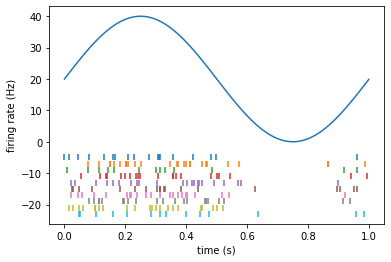

In [41]:
visualize_neuron = 0

t_spike = []
for t in range(trials):
    t_spike.append(neural_utils.BinToTrain(spikes[t, visualize_neuron]))

plt.plot(times, rate[0, visualize_neuron])
for n in range(trials):
    plt.scatter(t_spike[n]*tbin, (-5.0-2*n)*np.ones_like(t_spike[n]), marker='|')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.show()

In [91]:
l = 0.1*np.ones((1, neurons)) # shape (input dimensions, output dimensions)
v = 1.*np.ones(neurons) # shape (output dimensions,)
kernels_tuples = [('variance', v), 
                  ('RBF', 'euclid', l)]
VI_tuples = [(None, None, None, 1)] # prior, var. dist., topology, dimensions

num_induc = 8
indps = np.linspace(0, max_time, num_induc)
inducing_points = indps[None, :, None].repeat(neurons, axis=0) # shape (output dims, time, input dims)

rate_model = neuroprob.nonparametrics.Gaussian_process(
    neurons, # number of neurons
    inducing_points, # initial inducing points                                          
    kernels_tuples, # kernels                                          
    VI_tuples, # priors and variational distributions                                          
    shared_kernel_params=False, # share all kernel parameters over output dims?                                          
    cov_type='factorized', # fit with full GP posterior covariance?                                          
    mean=np.zeros((neurons)), # initial GP mean
    inv_link='exp', # inverse link function
    kern_f='softplus' # kernel inverse link
)

rate_model.set_params(
    tbin, # time bin
    jitter=1e-5 # jitter (numerical stability)
)

In [92]:
# likelihood model
likelihood = neuroprob.likelihoods.Poisson(
    neurons, # number of neurons or output dimensions
    'exp' # inverse link function
)

likelihood.set_params(tbin, jitter=1e-5)

In [93]:
# put together in GLM framework
glm = neuroprob.inference.VI_optimized([rate_model], likelihood)
glm.preprocess(
    [covariates], # list of input regressors of GP
    covariates.shape[1], # number of timesteps in total
    spikes, # spike trains
    batch_size=1000 # batch size (over timesteps)
)
    
glm.to(dev) # move to GPU if available

nll_optimized(
  (likelihood): Poisson()
  (rate_model): ModuleList(
    (0): Gaussian_process(
      (kernel): Product(
        (kern0): Constant()
        (kern1): RBF()
      )
    )
  )
)

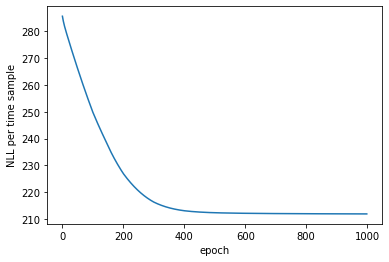

In [94]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (
    optim.Adam, # optimizer
    100, # scheduler time steps for iteration
    sch # scheduler effect
)
opt_lr_dict = {'default': 1e-2}

glm.set_optimizers(
    opt_tuple, 
    opt_lr_dict, 
    nat_grad=('rate_model.0.u_loc', 'rate_model.0.u_scale_tril'), 
    nat_lr=1e-1
    #newton_grad=('rate_model.0.u_loc',), 
    #newton_lr=1e-1
)

annealing = lambda x: 1.0
losses = glm.fit(
    1000, # number of max iterations
    loss_margin=0e0, 
    stop_iters=100, 
    anneal_func=annealing, 
    cov_samples=trials, # need to put in trials as we are doing regression over trials 
    ll_samples=20, 
    ll_mode='MC',
    bound='ELBO'
)

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

In [6]:
# compare to true rate
steps= 100
show_neurons = [0, 1]
eval_times = np.linspace(0.0, max_time, steps)[None, :] # shape (dims, timesteps)

lower, mean, upper = rate_model.eval_rate(eval_times, show_neurons, 'posterior')

visualize_trial = 0
fig, axes = plt.subplots(1, 2)
for k, neuron in enumerate(show_neurons):
    
    ax = axes[k]
    ax.plot(np.linspace(0, max_time, rate.shape[-1]), rate[visualize_trial, neuron], 'r--', label='true rate')
    line, = ax.plot(eval_times[0], mean[k], label='GP posterior')
    ax.fill_between(
        eval_times[0], lower[k],
        upper[k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
fig.tight_layout()


    
# draw tuning curves
tuning = rate_model.eval_rate(eval_times, show_neurons, 'tuning', n_samp=10)
fig, axes = plt.subplots(1, 2)
for k_n in range(len(show_neurons)):
    
    ax = axes[k_n]
    
    for n in range(samp):
        ax.plot(eval_times[0], tuning[n, k_n, ...])

    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')

fig.tight_layout()


# show GP posterior properties
steps= 100
show_neurons = [0, 1]
fig, axes = plt.subplots(1, 2)
for k, neuron in enumerate(show_neurons):
    
    Xu = glm.rate_model[0].Xu.data.cpu().numpy()[neuron, :, 0]
    eval_times = [np.linspace(Xu.min()-1.0, Xu.max()+1.0, steps)]
    lower, mean, upper = rate_model.eval_rate(eval_times, neuron, 'posterior')
    
    ax = axes[k]
    ax.scatter(Xu, -5.0*np.ones_like(Xu), marker='+', label='inducing points')
    line, = ax.plot(eval_times[0], mean, label='GP posterior')
    ax.fill_between(
        eval_times[0], lower,
        upper, color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
fig.tight_layout()
plt.show()

NameError: name 'rate_model' is not defined

<a id="likelihood"></a>
## Likelihood functions

In [3]:
likelihood_type = 'ZIP'# 'NB', 'ZIP', 'P'

In [4]:
neurons = 1
tbin = 0.1

### count process output ###
if likelihood_type == 'NB':
    r_inv = 0.0*torch.ones(neurons)
    likelihood = nprb.likelihoods.Negative_binomial(tbin, neurons, 'exp', r_inv)
elif likelihood_type == 'ZIP':
    alpha = 0.95*torch.ones(neurons)
    likelihood = nprb.likelihoods.ZI_Poisson(tbin, neurons, 'exp', alpha)
elif likelihood_type == 'CMP':
    log_nu = 1.*torch.ones(neurons)
    likelihood = nprb.likelihoods.COM_Poisson(tbin, neurons, 'exp', log_nu)
elif likelihood_type == 'P':
    likelihood = nprb.likelihoods.Poisson(tbin, neurons, 'exp')

### set data ###
max_count = 10
spikes = torch.arange(max_count)[None, :]
likelihood.set_Y(spikes, max_count)

### compute NLL ###
trials = 2
rates = 10.0*torch.ones(trials, neurons, max_count) # primary parameter
#disper_param = 0.1*torch.ones(trials, neurons, max_count) # dispersion parameter
nll = likelihood.nll(0, rates, spikes*torch.log(rates), spikes, range(neurons))#, disper_param=disper_param)

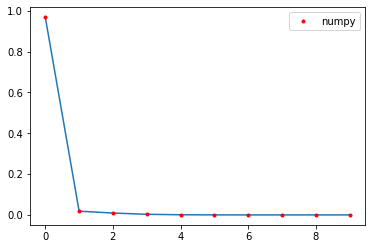

In [5]:
plt.plot(spikes[0, :], np.exp(-nll.data.numpy()[0, :]))
bins = np.arange(max_count)

if likelihood_type == 'NB':
    prbs = utils.stats.nb_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), r_inv[0].item(), 1.0)
elif likelihood_type == 'ZIP':
    prbs = utils.stats.zip_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), alpha[0].item(), 1.0)
elif likelihood_type == 'CMP':
    prbs = utils.stats.cmp_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), np.exp(log_nu[0].item()), 1.0)
elif likelihood_type == 'P':
    prbs = utils.stats.poiss_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), None, 1.0)
    
plt.plot(bins, prbs, 'r.', label=r'numpy')
plt.legend()
plt.show()

In [6]:
### sample ###
rate = np.linspace(0, 10, 100)[None, None, :].repeat(100, axis=0)*10
syn_train = likelihood.sample(rate, [0], XZ=None)


### empirical count mean and variance ###
m = syn_train.mean(0)
v = syn_train.var(0)

plt.scatter(m, v)

nx = np.linspace(0, m.max())
plt.plot(nx, nx*(1+nx*alpha.numpy()[0]))
plt.show()

plt.hist(syn_train.flatten(), bins=np.arange(max_count+1)-.5)
plt.show()

TypeError: __init__() missing 1 required positional argument: 'neurons'

In [8]:
### rebinning ###
bin_size = 100
rc_ts = []

for k in range(100):
    tbin, resamples, rc_t, _ = utils.neural.bin_data(bin_size, sample_bin, syn_train[k], 
                                                            syn_train.shape[-1], (), average_behav=False, binned=True)
    rc_ts.append(rc_t)
    
rc_ts = np.array(rc_ts)

NameError: name 'sample_bin' is not defined

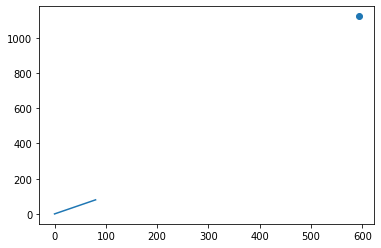

In [85]:
mean_act = (rc_ts).mean(0)
var_act = (rc_ts).var(0)

plt.scatter(mean_act, var_act)
nx = np.linspace(0, 80)
plt.plot(nx, nx*(1+nx*r_inv.numpy()[0]))
plt.show()

### Synthetic heteroscedastic model

In [2]:
# Gaussian von Mises bump head direction model
track_samples = 4000
hd_t = np.empty(track_samples)
hd_t[0] = 0#np.pi
rn = np.random.randn(track_samples)
for k in range(1, track_samples):
    hd_t[k] = hd_t[k-1] + 0.1*rn[k]
    
hd_t = hd_t % (2*np.pi)

In [3]:
sample_bin = 0.05
neurons = 50

# Von Mises fields
angle_0 = np.linspace(0, 2*np.pi, neurons+1)[:-1]
beta = 0.3
rate_0 = np.random.rand(neurons)*5.0 + 1.0
w = np.stack([np.log(rate_0), beta*np.cos(angle_0), beta*np.sin(angle_0)]).T # beta, phi_0 for theta modulation
neurons = w.shape[0]

vm_rate = nprb.rate_models.vonMises_GLM(neurons, inv_link='exp')
vm_rate.set_params(sample_bin, w)



# Dispersion tuning curve
_angle_0 = np.random.permutation(angle_0)
_beta = (0.2*np.random.randn(neurons))**2 + 0.01
_rate_0 = np.random.rand(neurons)*500.0 + 500.0
w = np.stack([np.log(_rate_0), _beta*np.cos(_angle_0), _beta*np.sin(_angle_0)]).T # beta, phi_0 for theta modulation

vm_disp = nprb.rate_models.vonMises_GLM(neurons, inv_link='exp')
vm_disp.set_params(sample_bin, w)


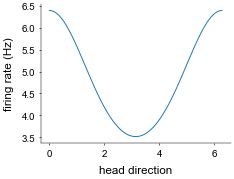

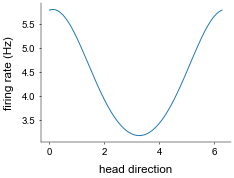

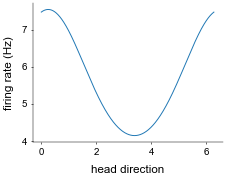

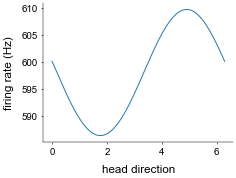

In [4]:
steps= 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

mean = vm_rate.eval_rate(covariates, show_neurons)
for k, neuron in enumerate(show_neurons):
    
    fig, ax = plt.subplots()
    line, = ax.plot(covariates[0], mean[0, k])
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')
    
plt.show()


steps= 1000
show_neurons = [0]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

mean = vm_disp.eval_rate(covariates, show_neurons)
for k, neuron in enumerate(show_neurons):
    
    fig, ax = plt.subplots()
    line, = ax.plot(covariates[0], mean[0, k])
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')
    
plt.show()

In [5]:
# Count process output
#r_inv = 10.*np.ones(neurons)
#alpha = 0.2*np.ones(neurons)
likelihood = nprb.likelihoods.Poisson(sample_bin, neurons, 'exp')
#likelihood = nprb.likelihoods.Negative_binomial(sample_bin, neurons, 'exp', r_inv, dispersion_mapping=None)
#likelihood = nprb.likelihoods.ZI_Poisson(sample_bin, neurons, 'exp', alpha)

trials = 1
ll_samples = 10
in_dims = 1

XZ = torch.tensor(hd_t[None, :, None]).float() # MC, T, D
F_mu, F_var = vm_rate.compute_F(XZ) 
rate = likelihood.sample_rate(F_mu, F_var, trials, ll_samples) # MC, trials, neuron, time

rate = rate.mean(0).numpy()
#h = nprb.inference.sample_F(vm_rate, likelihood, [hd_t], 10, list(range(neurons)))
syn_train = likelihood.sample(rate, XZ=XZ)

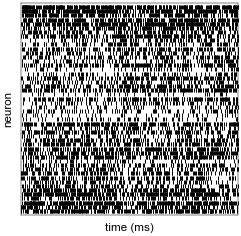

In [6]:
tr = 0
T = 1000

fig, ax = plt.subplots(figsize=(4,4))
utils.plot.raster_plot((fig, ax), syn_train[tr, :, :T], T, sample_bin*1000, neurons, markersize=10)
utils.plot.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

### Fitting SVGP

In [12]:
l = 10.*np.array([np.ones(1)])
v = np.ones(1)
kernels_tuples = [('variance', v), ('RBF', 'torus', l)]
VI_tuples = [(None, None, None, 1)]
ini_X = [hd_t]

In [17]:
cp = False

if cp is False:
    num_induc = 8
    inducing_points = np.linspace(0, 2*np.pi, num_induc+1)[None, :-1, None].repeat(neurons, axis=0)

    gpr = nprb.nonparametrics.Gaussian_process(
        in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
        inv_link='exp', whiten=True, jitter=1e-6, mean=np.zeros(neurons), learn_mean=True
    )

    gpd = nprb.nonparametrics.Gaussian_process(
        in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
        inv_link='exp', whiten=True, jitter=1e-6, mean=np.zeros(neurons), learn_mean=True
    )
    
    
    
else: # CP-SVGP 
    l = 1.*np.array([np.ones(neurons)])
    v = np.ones(neurons)
    #kernels_tuples = [('variance', v), ('RBF', 'torus', l)]
    K_list = [GP.kernels.Product(
        GP.kernels.Constant(variance=torch.tensor(v, dtype=torch.float)), 
        GP.kernels.RBF(input_dims=len(l), \
                       lengthscale=torch.tensor(l, dtype=torch.float), \
                       topology='torus'))
    ]

    track_dims_list = [[0]]
    kernel_TT = GP.kernels.KTT_kernel(K_list, track_dims_list)


    # inducing grid
    N_U = 100
    inducing_loc_list = [np.linspace(0, 2*np.pi, N_U+1)[None, None, :-1, None]]

    r_shape = (1,)
    nu_list = []
    Psi_list = []
    for u in inducing_loc_list:
        nu_list.append(np.zeros((neurons, *r_shape, u.shape[-2])))
        Psi_list.append(np.ones((neurons, u.shape[-2]))*0.1)

    #S_list = [np.eye(u.shape[-2])[None, ...].repeat(neurons, axis=0)]
    #S_type = GP.linalg.general_matrix
    k_V = 3
    S_list = [np.zeros((neurons, u.shape[-2]-1))]*k_V
    S_type = GP.linalg.trilI_Toeplitz_matrix


    # mapping
    gpr = nprb.nonparametrics.KCP_SVGP(
        in_dims, neurons, kernel_TT, inducing_loc_list, nu_list, Psi_list, S_list, S_type, 
        cheb_n=100, cheb_mc=1, GR_K=1, tr_mc=10, logdet_cheb=[True]*len(inducing_loc_list), jitter=1e-4, 
        nu_rshape_len=1, inv_link='exp', mean=np.zeros(neurons), learn_mean=True
    )

In [18]:
### inputs and likelihood ###
inputs = nprb.inference.input_group(in_dims, VI_tuples)
inputs.set_XZ(ini_X, track_samples, batch_size=1000, filter_len=1)  

likelihood = nprb.likelihoods.Poisson(sample_bin, neurons, 'exp')
#r_inv = 10.*np.ones(neurons)
#likelihood = nprb.likelihoods.Negative_binomial(sample_bin, neurons, 'exp', r_inv)
#alpha = .1*np.ones(neurons)
#likelihood = nprb.likelihoods.ZI_Poisson(sample_bin, neurons, 'exp', alpha, dispersion_mapping=None)
likelihood.set_Y(syn_train, batch_size=1000, filter_len=1) 


glm = nprb.inference.VI_optimized(inputs, gpr, likelihood)
glm.to(dev)

VI_optimized(
  (inputs): input_group()
  (mapping): Gaussian_process(
    (kernel): Product(
      (kern0): Constant()
      (kern1): RBF()
    )
  )
  (likelihood): Poisson()
)

In [19]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-3}

glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, bound='ELBO', ll_mode='MC')

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

KeyboardInterrupt: 

In [12]:
gpr.S[0].tensor_list[0].tensor

tensor([[[[-0.0727, -0.0680, -0.0653,  ...,  0.0042,  0.0044,  0.0008]],

         [[-0.0738, -0.0679, -0.0603,  ..., -0.0027, -0.0072, -0.0016]],

         [[-0.0634, -0.0586, -0.0547,  ..., -0.0028,  0.0006,  0.0022]],

         ...,

         [[-0.0731, -0.0663, -0.0600,  ...,  0.0016, -0.0018, -0.0079]],

         [[-0.0761, -0.0702, -0.0654,  ..., -0.0069, -0.0023, -0.0020]],

         [[-0.0694, -0.0637, -0.0627,  ..., -0.0122, -0.0100,  0.0016]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [13]:
gpr.Psi.tensor_list[0].tensor#_list[0]

tensor([[[[0.0990, 0.0990, 0.1010,  ..., 0.0990, 0.1010, 0.0990]],

         [[0.0990, 0.0990, 0.0990,  ..., 0.1010, 0.0990, 0.0990]],

         [[0.1010, 0.0990, 0.0990,  ..., 0.0990, 0.0990, 0.0990]],

         ...,

         [[0.0990, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010]],

         [[0.0990, 0.0990, 0.1010,  ..., 0.0990, 0.0990, 0.1010]],

         [[0.1010, 0.0990, 0.1010,  ..., 0.1010, 0.1010, 0.0990]]]],
       device='cuda:0')

In [14]:
gpr.Psi_list[0].grad

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

### Inspect posterior

In [15]:
#print(glm.likelihood.alpha)

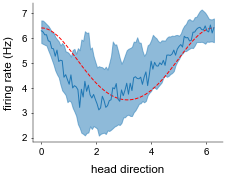

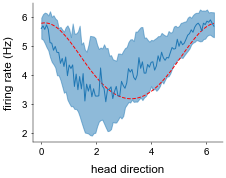

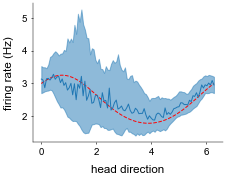

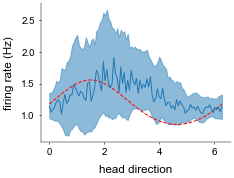

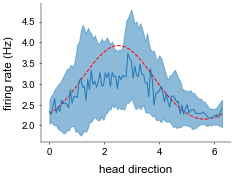

In [20]:
steps= 100
show_neurons = [0, 1, 6, 12, 20]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

r_true = vm_rate.eval_rate(covariates, show_neurons)

lower, mean, upper = gpr.eval_rate(covariates, show_neurons, 'posterior', n_samp=10)
for k, neuron in enumerate(show_neurons):

    fig, ax = plt.subplots()
    ax.plot(covariates[0], r_true[0, k], 'r--')
    line, = ax.plot(covariates[0], mean[0, k])
    ax.fill_between(
        covariates[0], lower[0, k],
        upper[0, k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')

plt.show()

### Compute statistics

In [93]:
def get_field(glm_rate, grid_size, grid_shape, neuron):

    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = [x, y]
        return glm_rate.eval_rate(covariates, neuron).reshape(-1, *prevshape)

    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    return field


def compute_rate(glm_rate, neuron):
    grid_size = [50, 40]
    grid_shape = [[left_x, right_x], [bottom_y, top_y]]
    field = get_field(glm_rate, grid_size, grid_shape, neuron)
    return field

def compute_stats(glm, spktrain, behav_list): # statistics
    glm_rate = glm.rate_model[0]
    glm_lik = glm.likelihood
    
    bs = 5000
    T = 100000
    traj_len = 1
    N = int(np.ceil(T/bs))
    rate_model = []
    spktrain = spktrain[:T]

    for n in range(N):
        covariates_ = [b[n*bs:(n+1)*bs] for b in behav_list]
        rate_model += [glm_rate.eval_rate(covariates_, [0])[0]]

    rate_model = np.concatenate(rate_model)

    f_p = lambda c, avg, shape, t: stats.nb_count_prob(c, avg, shape, t)
    m_f = lambda x: x
    cnt_tuple = stats.count_KS_method(f_p, m_f, glm_rate.tbin.item(), spktrain, rate_model, \
                                      traj_len, shape=glm_lik.r_inv[0].item(), min_spikes=0)
    q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS, traj_lens = cnt_tuple

    return q_cdf, Z_DS, T_KS, s_KS

In [94]:
q_cdf, Z_DS, T_KS, s_KS = compute_stats(glm, rc_t[0], [rhd_t])

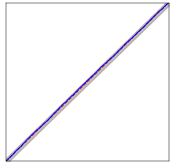

0.0095291454015618
-0.14628394160774894


In [95]:
fig = plt.figure(figsize=(3, 3))
ax = fig.subplots()
ax = stats.plot_dispersion(ax, q_cdf, s_KS)
plt.show()
print(T_KS)
print(Z_DS)